<a href="https://colab.research.google.com/github/roy-sh/automated-trading/blob/main/automated_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow -qqq
!pip install keras -qqq
!pip install yfinance -qqq
!pip install mplfinance -qqq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
# print("TensorFlow Version: ", tf.__version__)


TensorFlow Version:  2.15.0


In [5]:
# Fetch AAPL data
stock_data = yf.download('MARA', start='2020-01-01', end='2024-05-22')

# Display the first few rows of the dataframe
stock_data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,0.88,1.08,0.88,1.05,1.05,447600
2020-01-03,0.99,1.00,0.93,0.96,0.96,128000
2020-01-06,0.96,1.06,0.96,0.97,0.97,192100
2020-01-07,0.98,1.12,0.98,1.09,1.09,1039100
2020-01-08,1.13,1.13,0.92,0.95,0.95,487700


In [6]:
# Checking for missing values
stock_data.isnull().sum()

# Filling missing values, if any
stock_data.fillna(method='ffill', inplace=True)
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-15,18.870001,20.230000,17.980000,20.200001,20.200001,53512000
2024-05-16,19.850000,20.440001,19.330000,19.650000,19.650000,32569100
2024-05-17,20.190001,20.879999,19.260000,19.450001,19.450001,48373500
2024-05-20,19.680000,22.820000,18.870001,22.320000,22.320000,66423200
2024-05-21,22.230000,22.549999,21.120001,21.350000,21.350000,45107300


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
stock_data_scaled = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))


In [8]:
X = []
y = []

for i in range(60, len(stock_data_scaled)):
    X.append(stock_data_scaled[i-60:i, 0])
    y.append(stock_data_scaled[i, 0])


In [9]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [10]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1)))
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))




In [12]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())


In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [16]:
# Assume 'data' is your preprocessed dataset
train_size = int(len(stock_data) * 0.8)
train_data, test_data = stock_data[:train_size], stock_data[train_size:]


In [17]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 permute (Permute)           (None, 50, 60)            0         
                                                                 
 reshape (Reshape)           (None, 50, 60)            0         
                                                                 
 permute_1 (Permute)         (None, 60, 50)            0         
                                                                 
 reshape_1 (Reshape)         (None, 60, 50)            0         
                                                                 
 flatten (Flatten)           (None, 3000)              0

In [18]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)


In [19]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Callback to save the model periodically
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)


Epoch 1/100
27/27 [==============================] - 8s 41ms/step - loss: 0.2571 - val_loss: 0.0105 - lr: 0.0010
Epoch 2/100
13/27 [=============>................] - ETA: 0s - loss: 0.0776

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 13ms/step - loss: 0.0672 - val_loss: 0.0061 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0518 - val_loss: 0.0036 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0439 - val_loss: 0.0025 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0373 - val_loss: 0.0019 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0282 - val_loss: 0.0020 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 0s 11ms/step - loss: 0.0251 - val_loss: 0.0034 - lr: 0.0010
Epoch 8/100
27/27 [==============================] - 0s 11ms/step - loss: 0.0226 - val_loss: 0.0046 - lr: 0.0010
Epoch 9/100
27/27 [==============================] - 0s 11ms/step - loss: 0.0216 - val_loss: 0.0057 - lr: 0.0010
Epoch 10/100
27/27 [==============================] - 0s 11ms/step - loss: 0.0166 - val_loss: 0.0068 - lr: 0

In [20]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)



7/7 [==============================] - 0s 6ms/step - loss: 0.0047
Test Loss:  0.004699902608990669


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)


7/7 [==============================] - 0s 4ms/step
Mean Absolute Error:  0.05589107551355657
Root Mean Square Error:  0.0685558292386092


In [42]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta


def predict_stock_price(input_date, ndays=10):
    # Check if the input date is a valid date format
    try:
        input_date = pd.to_datetime(input_date)
    except ValueError:
        print("Invalid Date Format. Please enter date in YYYY-MM-DD format.")
        return

    # Fetch data from yfinance
    end_date = input_date
    start_date = input_date - timedelta(days=90)  # Fetch more days to ensure we have 60 trading days
    data = yf.download('MARA', start=start_date, end=end_date)


    if len(data) < 60:
        print("Not enough historical data to make a prediction. Try an earlier date.")
        return

    # Prepare the data
    closing_prices = data['Close'].values[-60:]  # Last 60 days
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

    # Make predictions
    predicted_prices = []
    current_batch = scaled_data.reshape(1, 60, 1)

    for i in range(ndays):  # Predicting 4 days
        next_prediction = model.predict(current_batch)
        next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
        current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
        predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])
    # Creating a list of dates for the predictions
    last_date = data.index[-1]
    next_day = last_date + pd.Timedelta(days=1)
    prediction_dates = pd.date_range(start=next_day, periods=ndays)
    # Output the predictions
    for i, price in enumerate(predicted_prices, 1):
        print(f"Day {i} prediction: {price}")
    # Adding predictions to the DataFrame
    predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

    # Combining both actual and predicted data
    combined_data = pd.concat([data['Close'], predicted_data['Close']])
    combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

    # Plotting the actual data
    plt.figure(figsize=(10,6))
    plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

    # Plotting the predicted data
    plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

    plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()



Enter a date (YYYY-MM-DD) to predict AAPL stock for the next 4 days: 2024-05-15


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
Day 1 prediction: 17.8004207611084
Day 2 prediction: 17.81529426574707
Day 3 prediction: 17.786605834960938
Day 4 prediction: 17.76166534423828
Day 5 prediction: 17.721792221069336
Day 6 prediction: 17.729175567626953
Day 7 prediction: 17.699127197265625
Day 8 prediction: 17.71929931640625
Day 9 prediction: 17.674291610717773
Day 10 prediction: 17.622821807861328


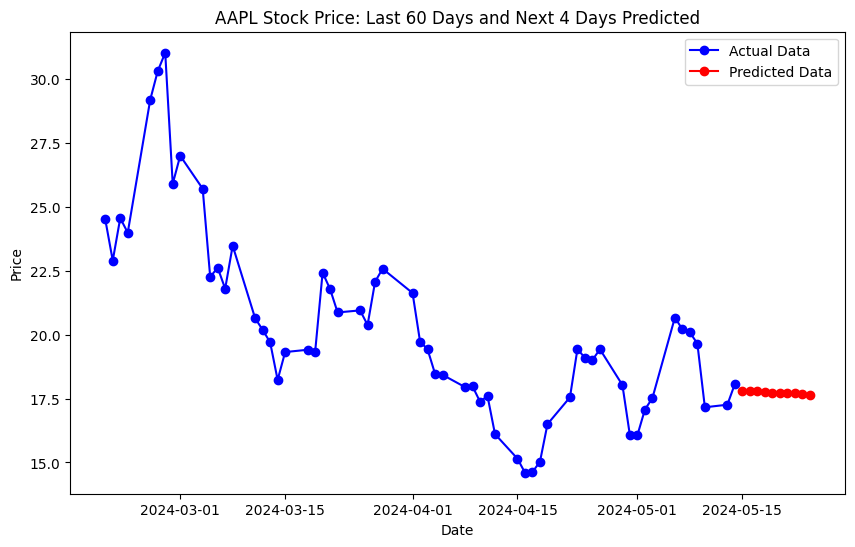

In [44]:

# Example use
user_input = input("Enter a date (YYYY-MM-DD) to predict AAPL stock for the next 4 days: ")
predict_stock_price(user_input)
